### Import libraries and data

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
)
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('data/unique_outages2.csv', parse_dates=['Start', 'Finish', 'file_name'])
df['Duration_Category'].value_counts()

Duration_Category
11.0–14.0 hrs    649
20.8+ hrs        558
9.5–11.0 hrs     525
2.8–9.5 hrs      395
0–2.8 hrs        114
14.0–20.8 hrs     30
Name: count, dtype: int64

### Function for model training 

In [7]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score,
    f1_score, precision_score, recall_score
)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd


def train_with_cross_validation(df, n_folds=5, random_state=42, fine_tune=False, params=None):
    """
    Implement k-fold cross-validation on the RandomForest classification model.
    
    Args:
        df: Pandas DataFrame with features and target
        n_folds: Number of folds for cross-validation
        random_state: Random seed for reproducibility
        fine_tune: Whether to perform hyperparameter tuning (GridSearchCV)
        params: Hyperparameters to be passed to the model, if fine_tune is False
        
    Returns:
        Trained model on the full dataset and cross-validation results
    """
    
    # --- 1. Select Features and Target (same as original)
    features = ['Recall_Day_Hours', 'Recall_Night_Hours',  # numerical columns
                'Project Work?', 'DNSP Aware?', 'Generator Aware?', 'Inter-Regional',  # boolean columns
                'Region', 'NSP', 'Asset Type', 'Reason', 'Status_Code', 'Status_Description'  # categorical columns
                ] 
    target = 'Duration_Category'

    X = df[features].copy()
    y = df[target]
    
    # --- 2. Encode Categorical Features (same as original)
    for col in ['Region', 'NSP', 'Asset Type', 'Reason', 'Status_Code', 'Status_Description']:
        X[col] = LabelEncoder().fit_transform(X[col])
    
    # --- 3. Define model
    model = RandomForestClassifier(random_state=random_state, class_weight='balanced')
    
    # --- 4. Hyperparameter tuning if needed
    if fine_tune:
        print("Performing GridSearchCV to find the best parameters...")
        param_grid = {
            'n_estimators': [50, 100, 150],  # Number of trees in the forest
            'max_depth': [None, 10, 20, 30],  # Depth of the trees
            'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
            'min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
            'bootstrap': [True, False]  # Whether bootstrap samples are used
        }

        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                                   cv=n_folds, n_jobs=-1, verbose=0, scoring='accuracy')
        grid_search.fit(X, y)
        model = grid_search.best_estimator_
        print(f"Best Hyperparameters from GridSearchCV: {grid_search.best_params_}")
    
    elif params is not None:
        # Use provided hyperparameters
        print(f"Using provided parameters: {params}")
        model = RandomForestClassifier(random_state=random_state, **params)
        model.fit(X, y)
    else:
        # If no hyperparameters and no fine-tuning, train with default RandomForest parameters
        print("Training with default RandomForest parameters...")
        model.fit(X, y)
    
    # --- 5. Set up k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    
    # --- 6. Define metrics to track
    scoring = {
        'accuracy': 'accuracy',
        'precision_weighted': 'precision_weighted',
        'recall_weighted': 'recall_weighted',
        'f1_weighted': 'f1_weighted'
    }
    
    # --- 7. Perform cross-validation
    cv_results = cross_validate(
        model, X, y, 
        cv=kf, 
        scoring=scoring,
        return_train_score=True,
        return_estimator=True  # This will return the models trained in each fold
    )
    
    # --- 8. Display cross-validation results
    print(f"Cross-Validation Results ({n_folds}-fold):")
    
    # Print Test Metrics
    print(f"Test Accuracy: {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
    print(f"Test Precision: {cv_results['test_precision_weighted'].mean():.4f} ± {cv_results['test_precision_weighted'].std():.4f}")
    print(f"Test Recall: {cv_results['test_recall_weighted'].mean():.4f} ± {cv_results['test_recall_weighted'].std():.4f}")
    print(f"Test F1: {cv_results['test_f1_weighted'].mean():.4f} ± {cv_results['test_f1_weighted'].std():.4f}")
    
    # Print Mean Training Accuracy
    print(f"Train Accuracy: {cv_results['train_accuracy'].mean():.4f} ± {cv_results['train_accuracy'].std():.4f}")
    
    # --- 9. Visualize cross-validation results
    visualize_cv_results(cv_results)
    
    # --- 10. Visualize confusion matrices for each fold
    visualize_confusion_matrices(kf, cv_results, X, y, n_folds)
    
    # --- 11. Train final model on the full dataset
    model.fit(X, y)
    
    # --- 12. Display feature importances
    visualize_feature_importances(model, X.columns)
    
    return model, cv_results



def visualize_confusion_matrices(kf, cv_results, X, y, n_folds=5):
    """Visualize confusion matrices for each fold."""
    fig = plt.figure(figsize=(18, 4 * n_folds))  # Adjust figure size based on number of folds
    gs = gridspec.GridSpec(n_folds, 2)
    
    for i, (train_idx, test_idx) in enumerate(kf.split(X)):
        # Split data for this fold
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Get the estimator for this fold
        estimator = cv_results['estimator'][i]
        
        # Make predictions for train and test sets
        y_train_pred = estimator.predict(X_train)
        y_test_pred = estimator.predict(X_test)
        
        # Calculate accuracy for train and test
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        
        # Get present labels (classes that actually exist in this fold)
        present_labels = sorted(set(y))
        
        # Train confusion matrix
        ax1 = fig.add_subplot(gs[i, 0])
        cm_train = confusion_matrix(y_train, y_train_pred, labels=present_labels)
        disp_train = ConfusionMatrixDisplay(cm_train, display_labels=present_labels)
        disp_train.plot(ax=ax1, cmap='viridis', xticks_rotation=45, values_format='d', colorbar=False)
        ax1.set_title(f"Fold {i+1}: Train Confusion Matrix (Acc: {train_acc:.2%})")
        
        # Test confusion matrix
        ax2 = fig.add_subplot(gs[i, 1])
        cm_test = confusion_matrix(y_test, y_test_pred, labels=present_labels)
        disp_test = ConfusionMatrixDisplay(cm_test, display_labels=present_labels)
        disp_test.plot(ax=ax2, cmap='viridis', xticks_rotation=45, values_format='d', colorbar=False)
        ax2.set_title(f"Fold {i+1}: Test Confusion Matrix (Acc: {test_acc:.2%})")
    
    plt.tight_layout()
    plt.show()


def visualize_cv_results(cv_results):
    """Visualize cross-validation metrics comparison and distribution."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot train vs test metrics
    metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
    train_means = [cv_results[f'train_{m}'].mean() for m in metrics]
    test_means = [cv_results[f'test_{m}'].mean() for m in metrics]
    train_stds = [cv_results[f'train_{m}'].std() for m in metrics]
    test_stds = [cv_results[f'test_{m}'].std() for m in metrics]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    ax1.bar(x - width/2, train_means, width, label='Train', color='darkcyan', yerr=train_stds)
    ax1.bar(x + width/2, test_means, width, label='Test', color='slateblue', yerr=test_stds)
    
    ax1.set_title('Cross-Validation Metrics')
    ax1.set_xticks(x)
    ax1.set_xticklabels([m.replace('_weighted', '').capitalize() for m in metrics])
    ax1.set_ylim([0, 1])
    ax1.legend()
    
    # Plot distribution of test accuracy across folds
    fold_numbers = range(1, len(cv_results['test_accuracy']) + 1)
    ax2.plot(fold_numbers, cv_results['test_accuracy'], 'o-', label='Accuracy', color='green')
    ax2.plot(fold_numbers, cv_results['test_f1_weighted'], 's-', label='F1', color='orange')
    ax2.axhline(cv_results['test_accuracy'].mean(), linestyle='--', color='darkgreen', alpha=0.7)
    ax2.axhline(cv_results['test_f1_weighted'].mean(), linestyle='--', color='darkorange', alpha=0.7)
    
    ax2.set_title('Metrics by Fold')
    ax2.set_xlabel('Fold')
    ax2.set_xticks(fold_numbers)
    ax2.set_ylim([0, 1])
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


def visualize_feature_importances(model, feature_names):
    """Visualize feature importances from the trained model."""
    plt.figure(figsize=(10, 6))
    
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.barh(np.array(feature_names)[indices], importances[indices], color='goldenrod')
    plt.xlabel('Importance')
    plt.title('Feature Importances (Full Dataset Model)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

### Import function for model evaluation

Performing GridSearchCV to find the best parameters...
Best Hyperparameters from GridSearchCV: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Cross-Validation Results (5-fold):
Test Accuracy: 0.6829 ± 0.0249
Test Precision: 0.7237 ± 0.0267
Test Recall: 0.6829 ± 0.0249
Test F1: 0.6898 ± 0.0269
Train Accuracy: 0.7334 ± 0.0088


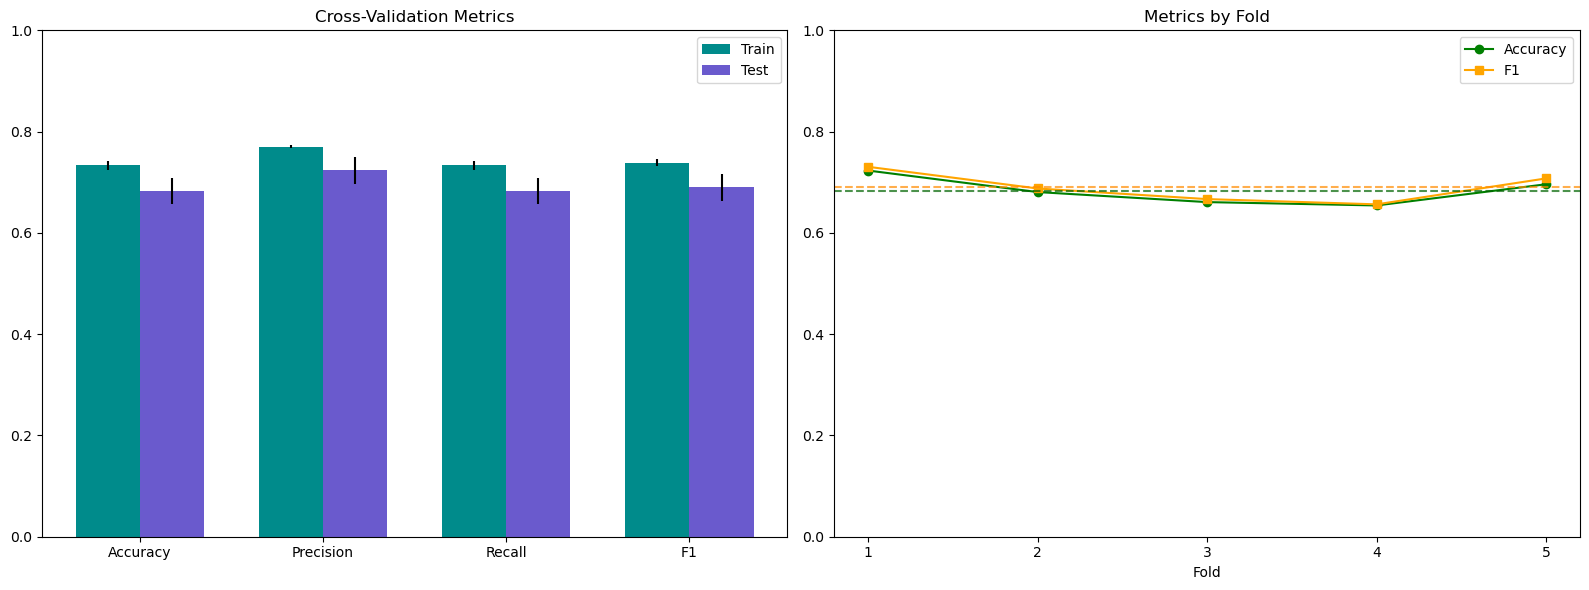

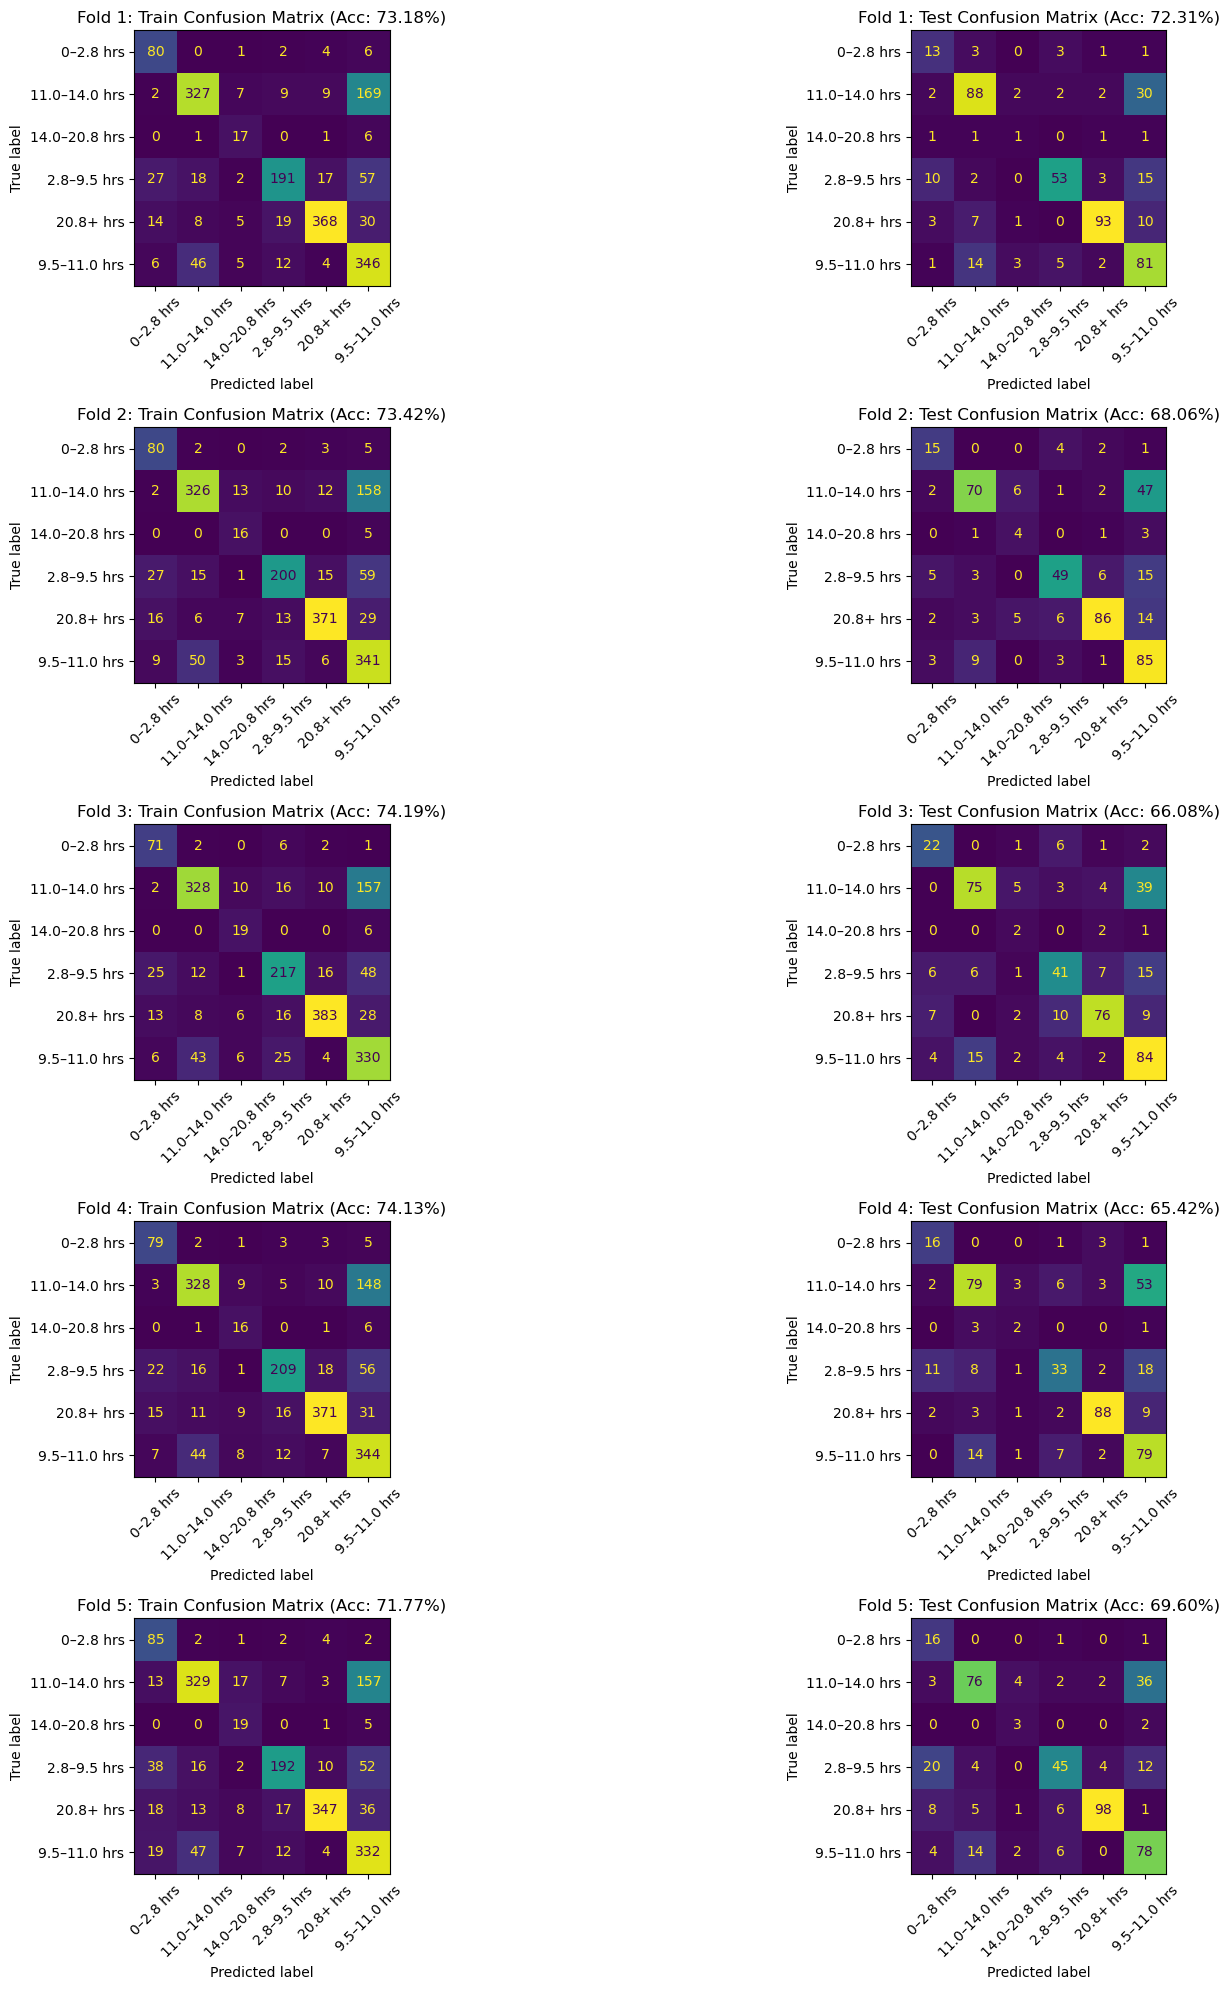

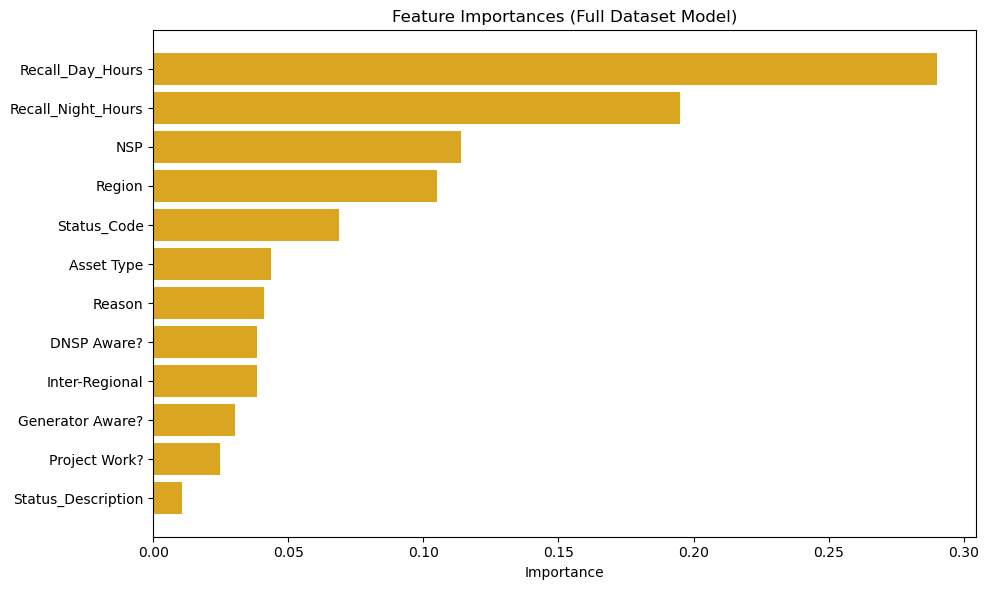

In [8]:
model, cv_results = train_with_cross_validation(df, n_folds=5, fine_tune=True)

### Model fitting on state-specific data

Training model for SA...
Using provided parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/m

Cross-Validation Results (5-fold):
Test Accuracy: 0.8532 ± 0.0620
Test Precision: 0.8459 ± 0.0623
Test Recall: 0.8532 ± 0.0620
Test F1: 0.8330 ± 0.0692
Train Accuracy: 0.8880 ± 0.0075


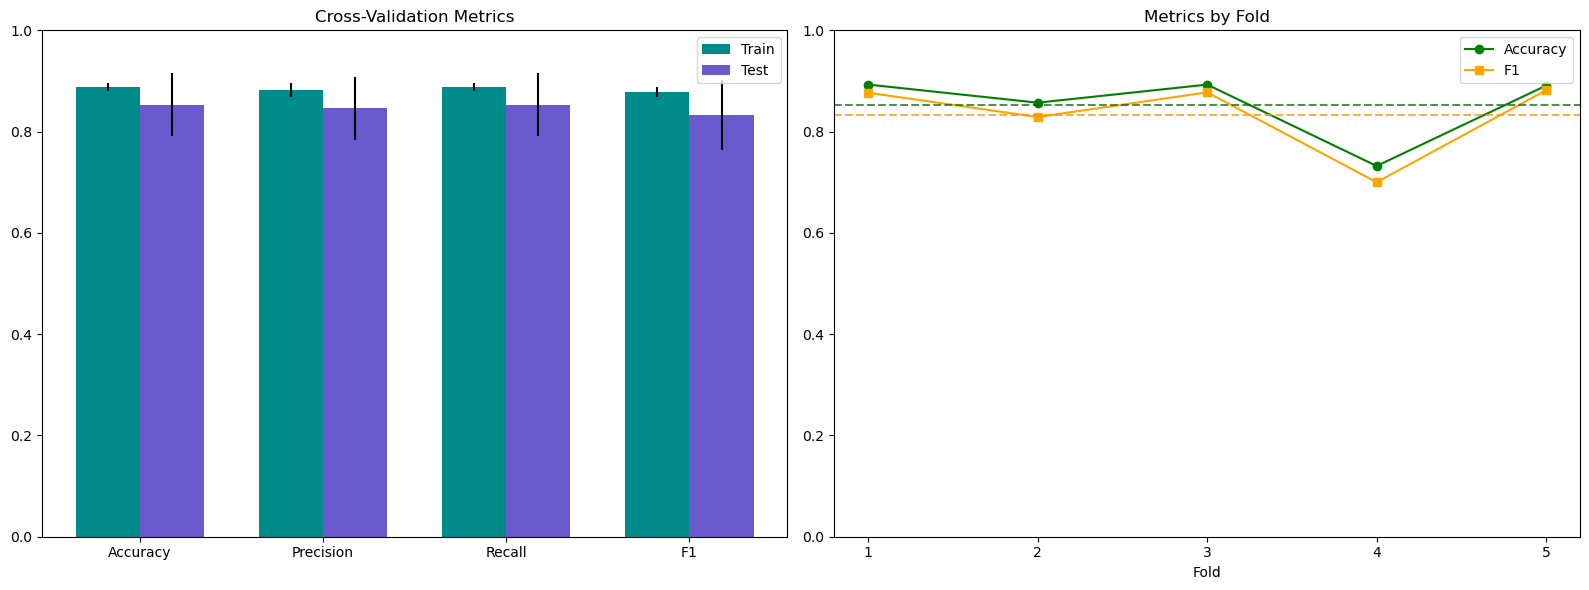

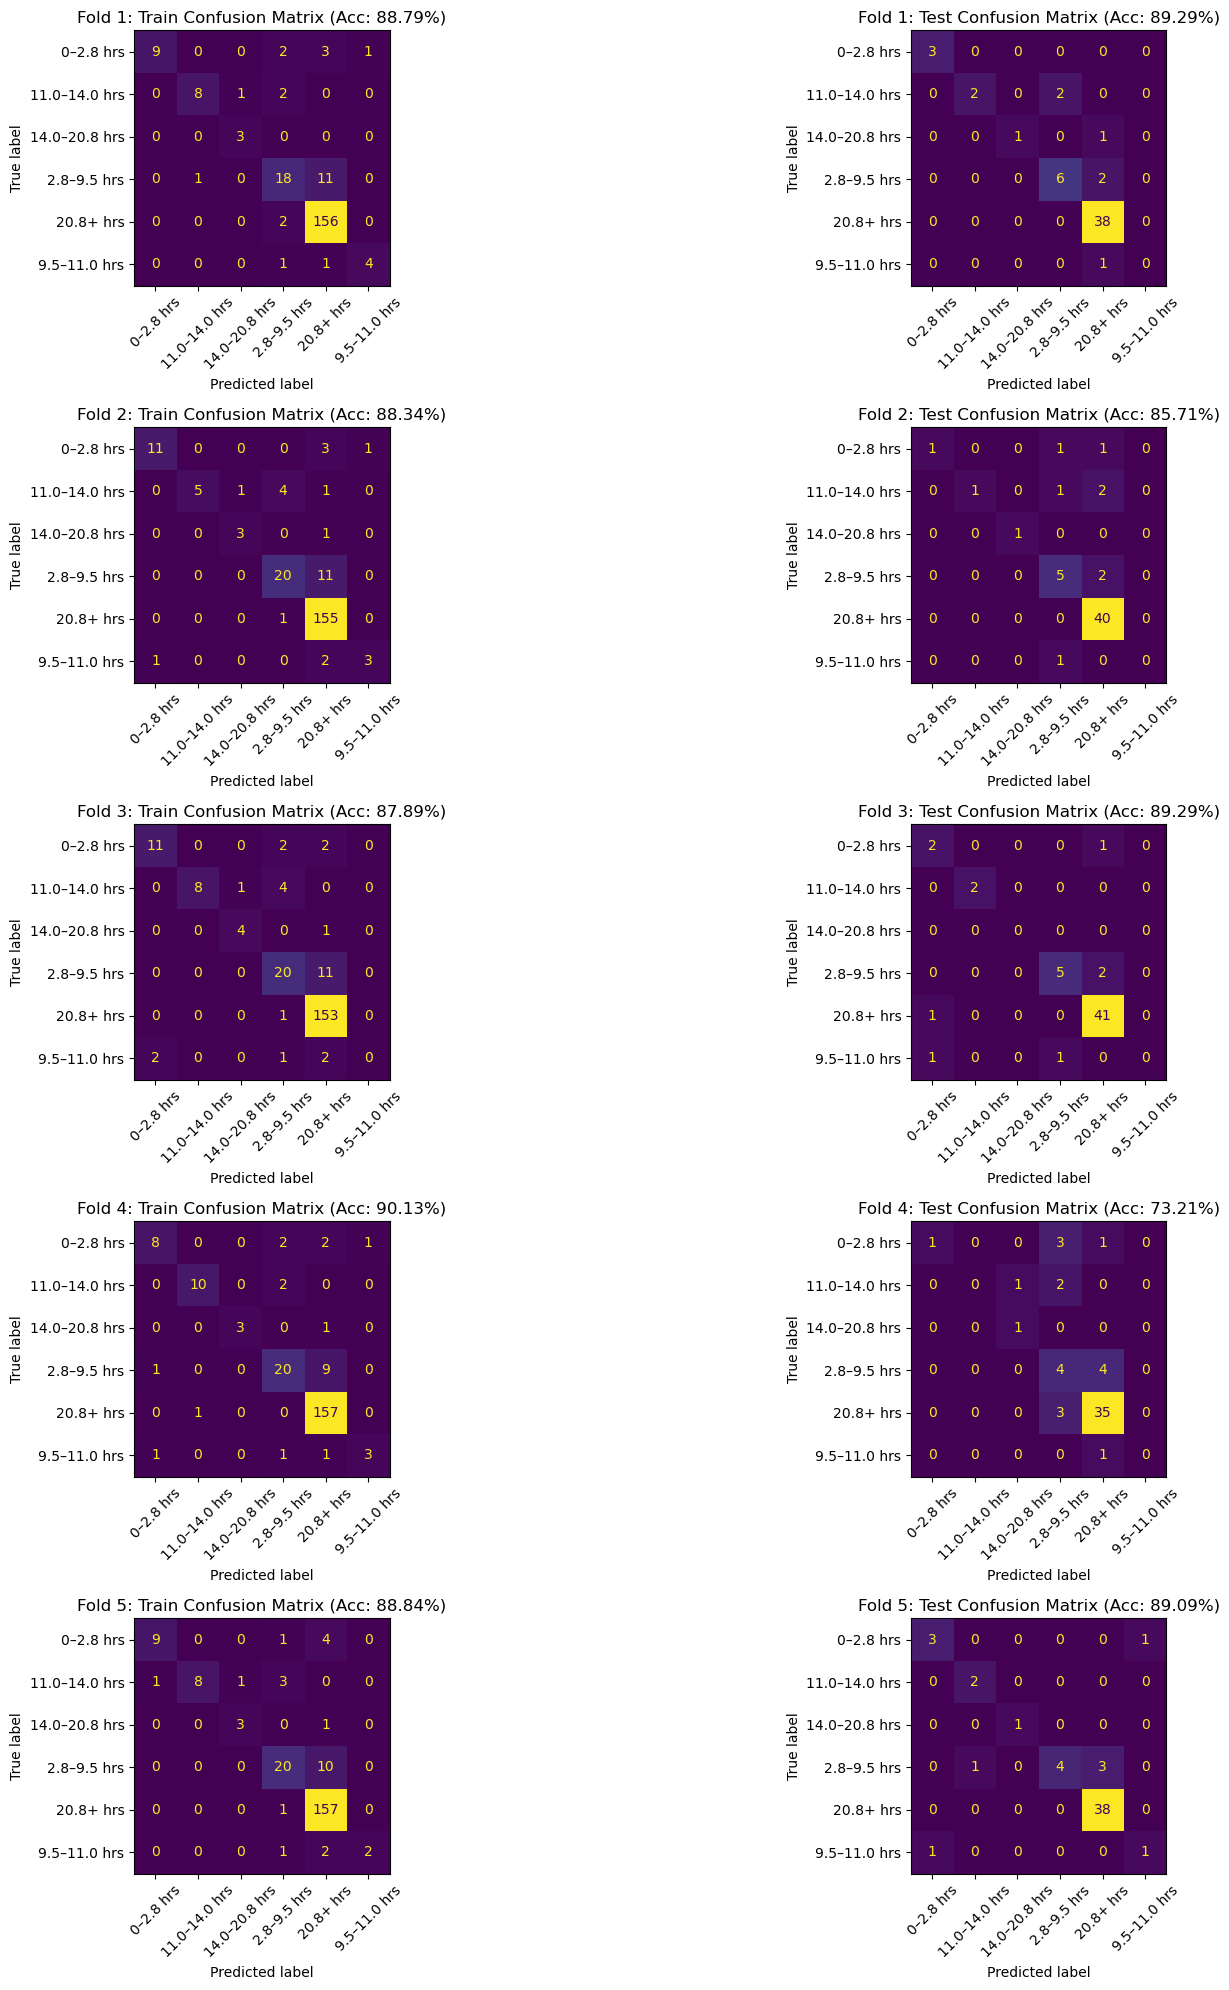

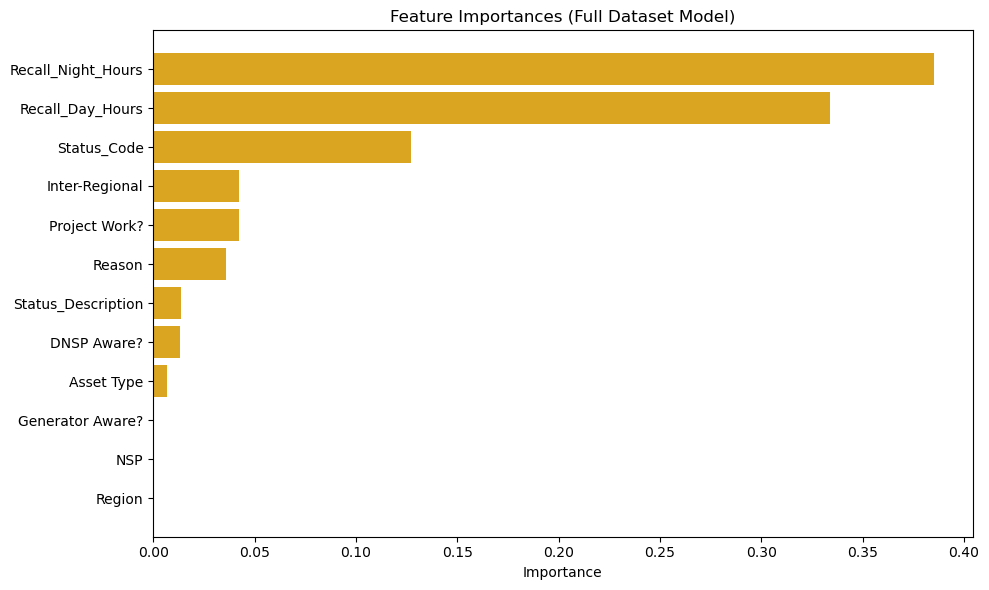

Training model for VIC...
Using provided parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/m

Cross-Validation Results (5-fold):
Test Accuracy: 0.6128 ± 0.0280
Test Precision: 0.6437 ± 0.0306
Test Recall: 0.6128 ± 0.0280
Test F1: 0.5934 ± 0.0335
Train Accuracy: 0.6603 ± 0.0105


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


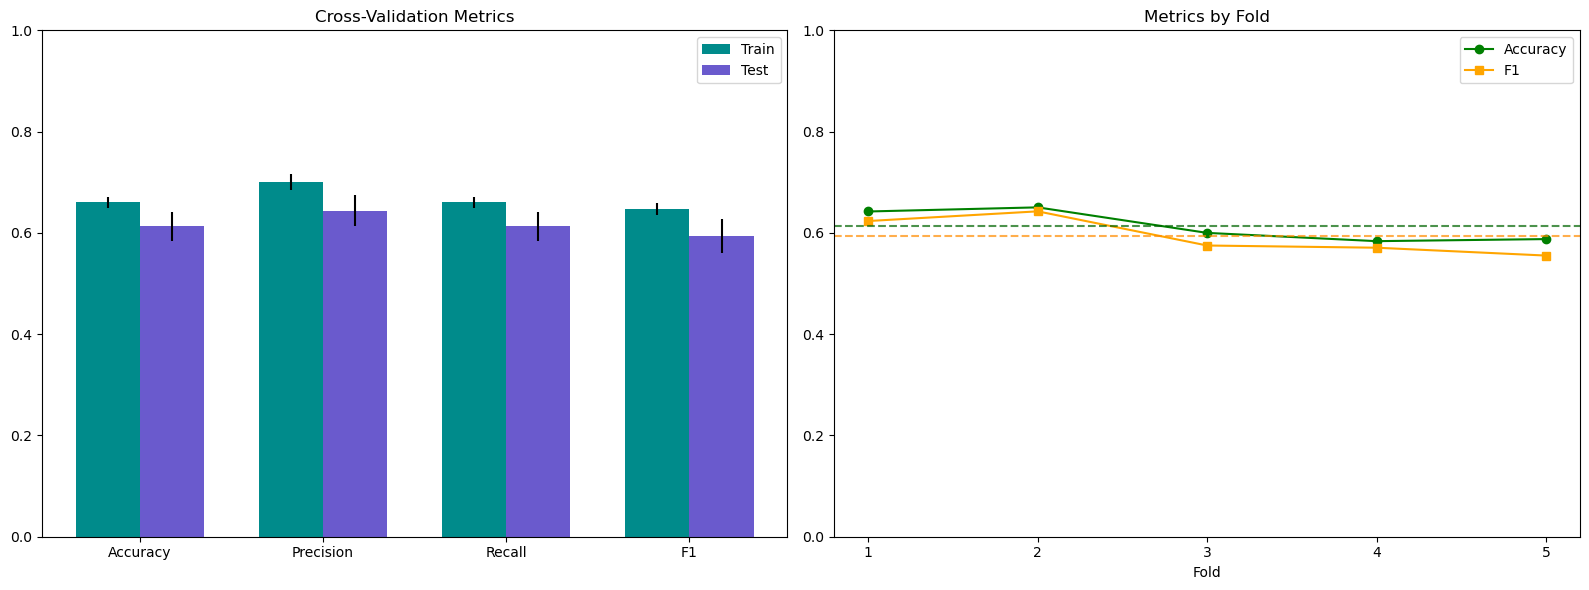

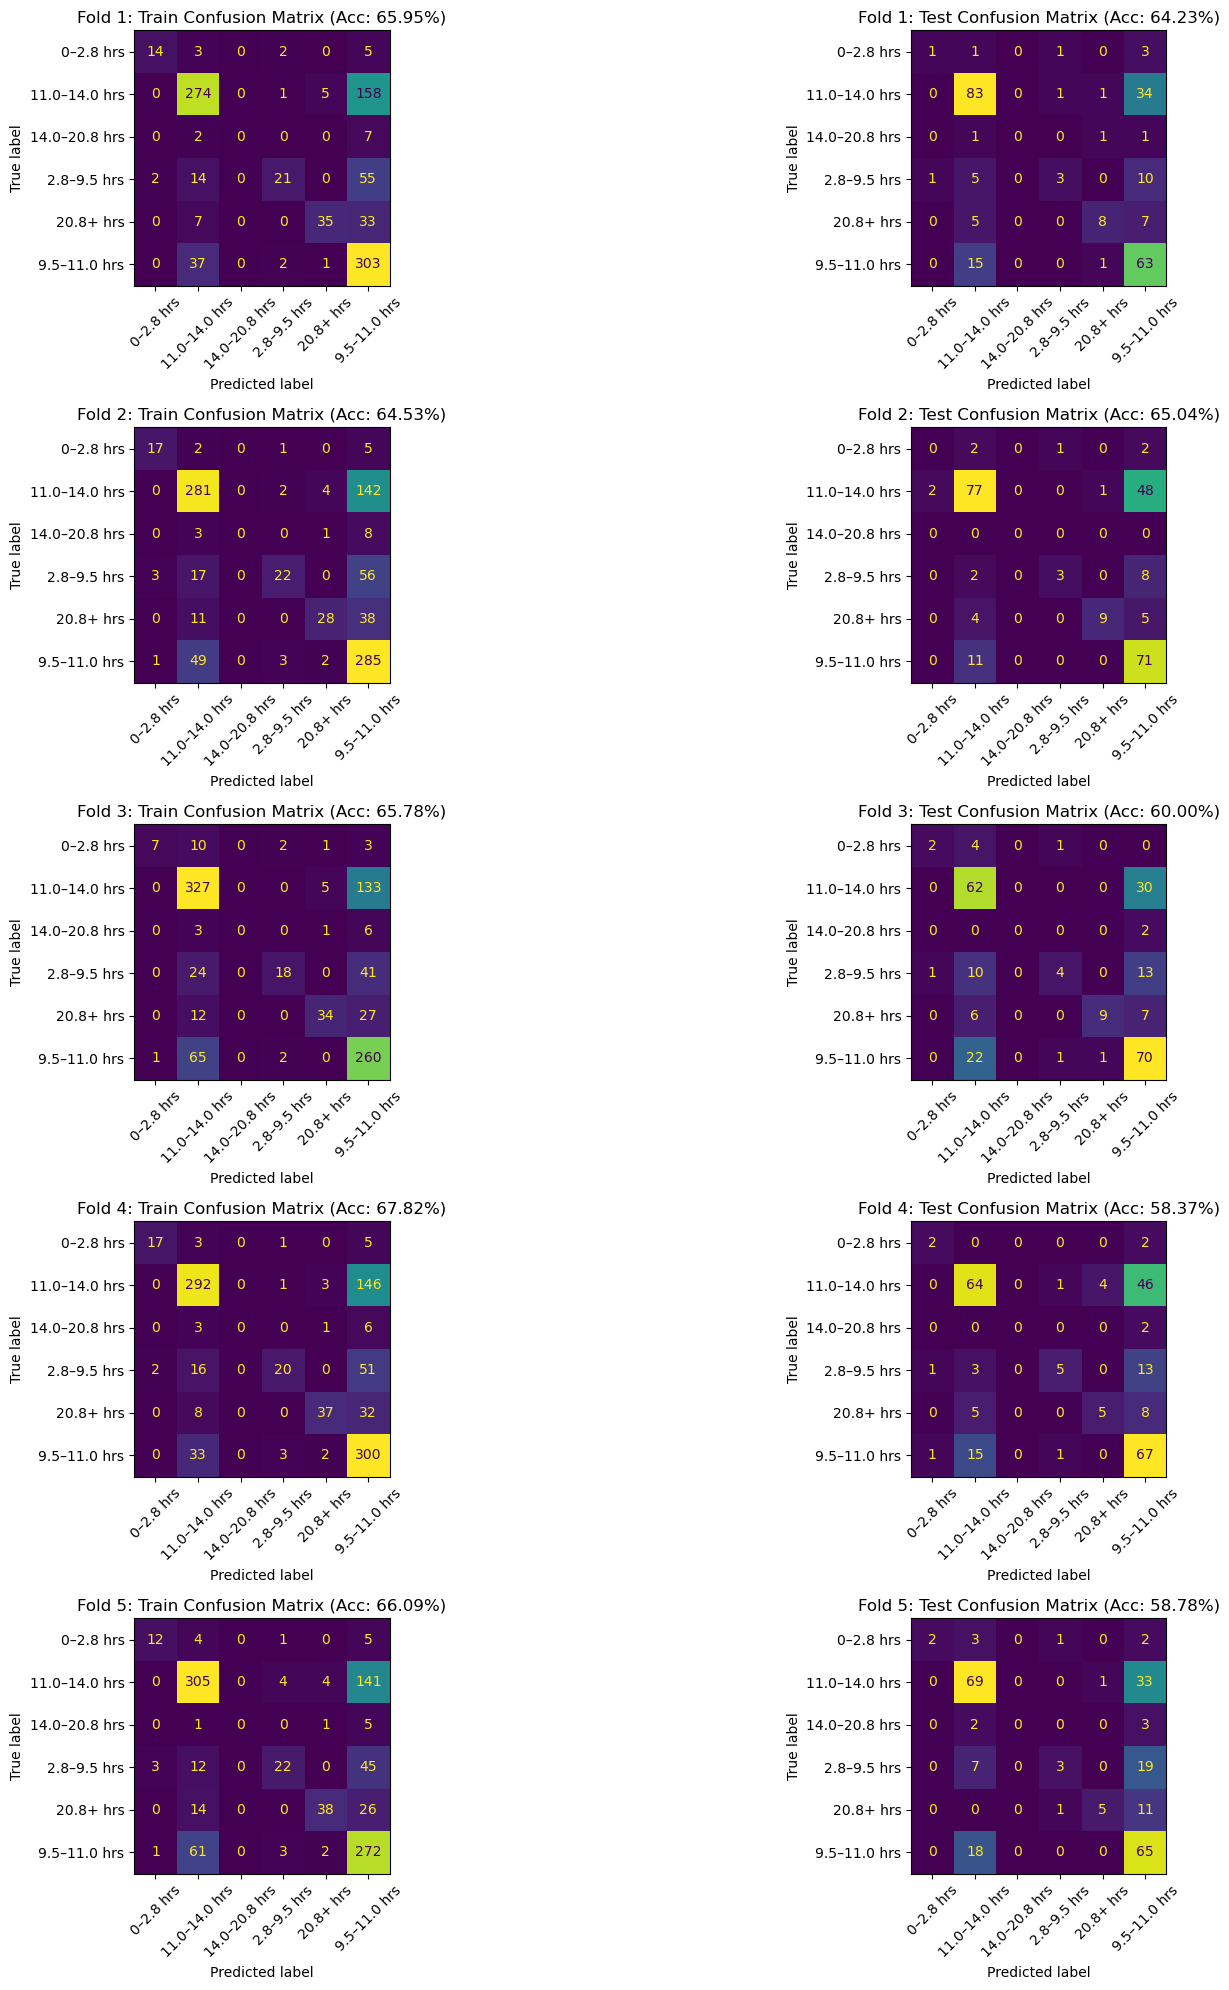

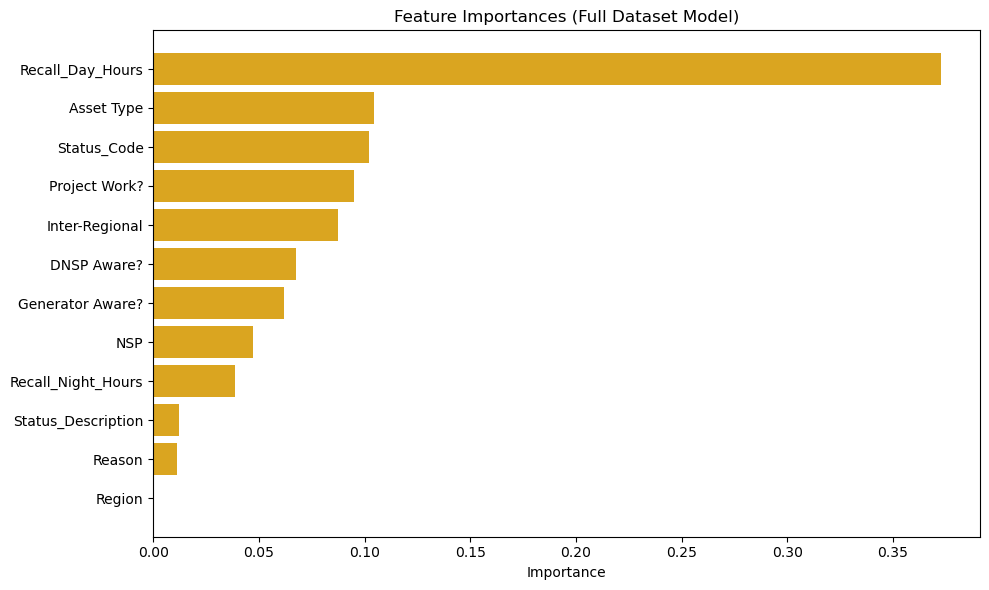

Training model for TAS...
Using provided parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/m

Cross-Validation Results (5-fold):
Test Accuracy: 0.7630 ± 0.0554
Test Precision: 0.7684 ± 0.0882
Test Recall: 0.7630 ± 0.0554
Test F1: 0.7507 ± 0.0651
Train Accuracy: 0.8241 ± 0.0143


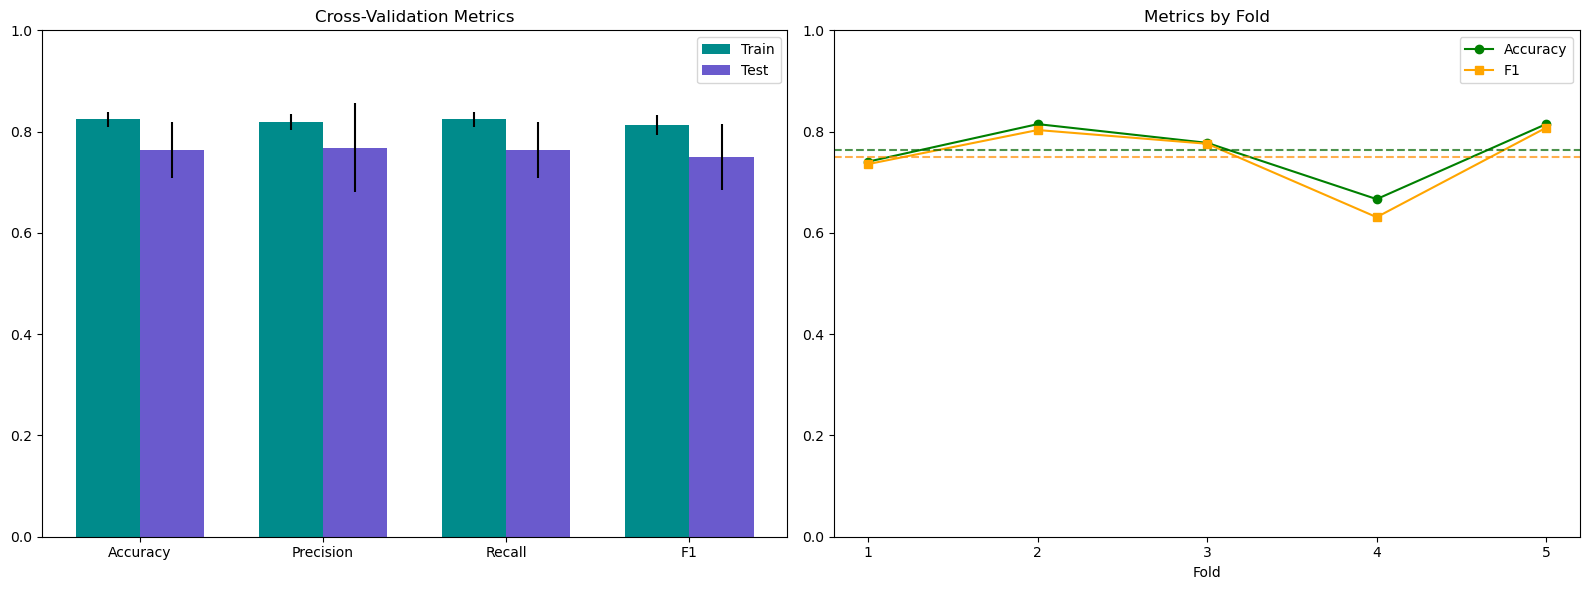

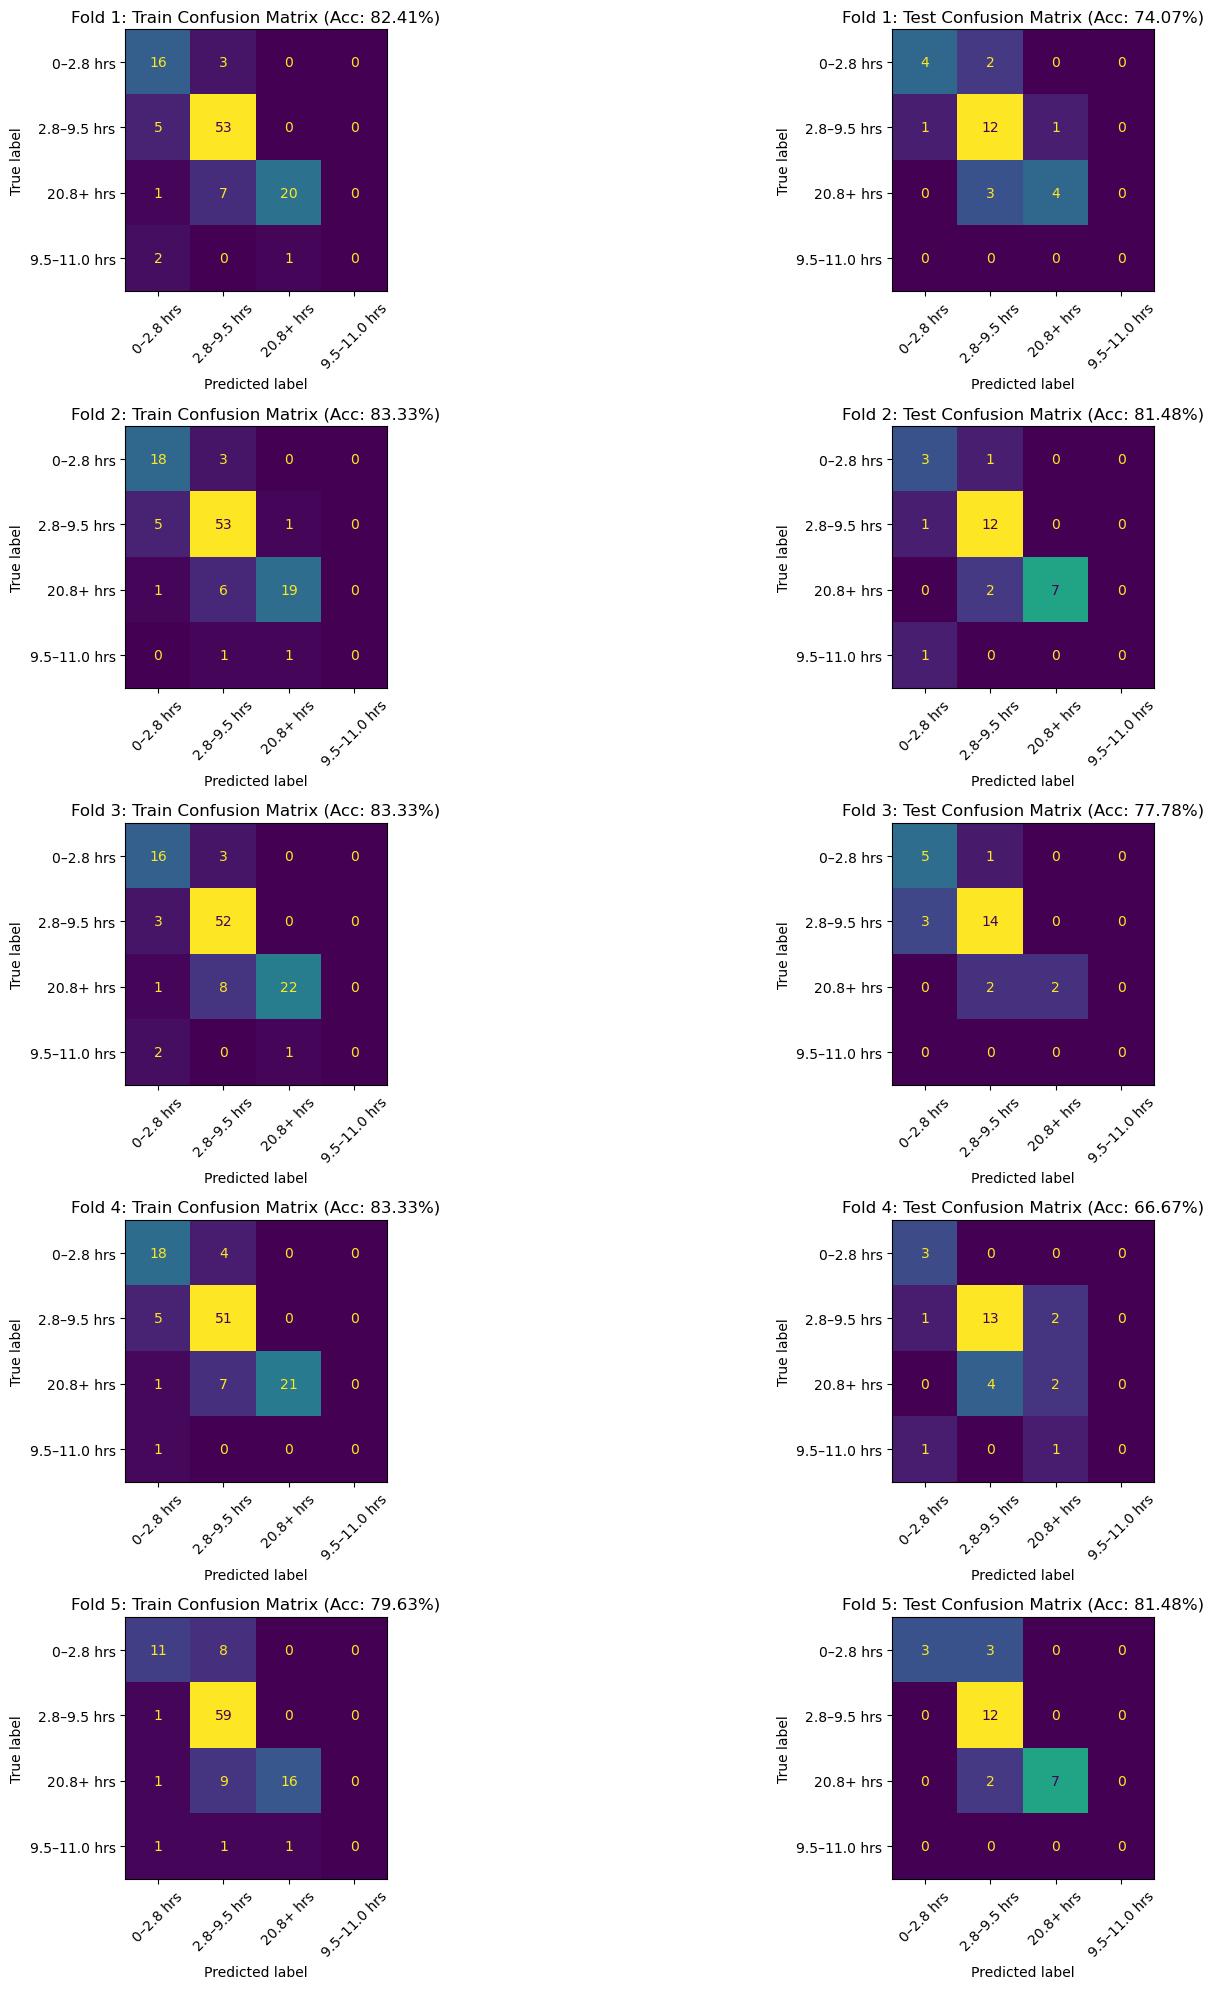

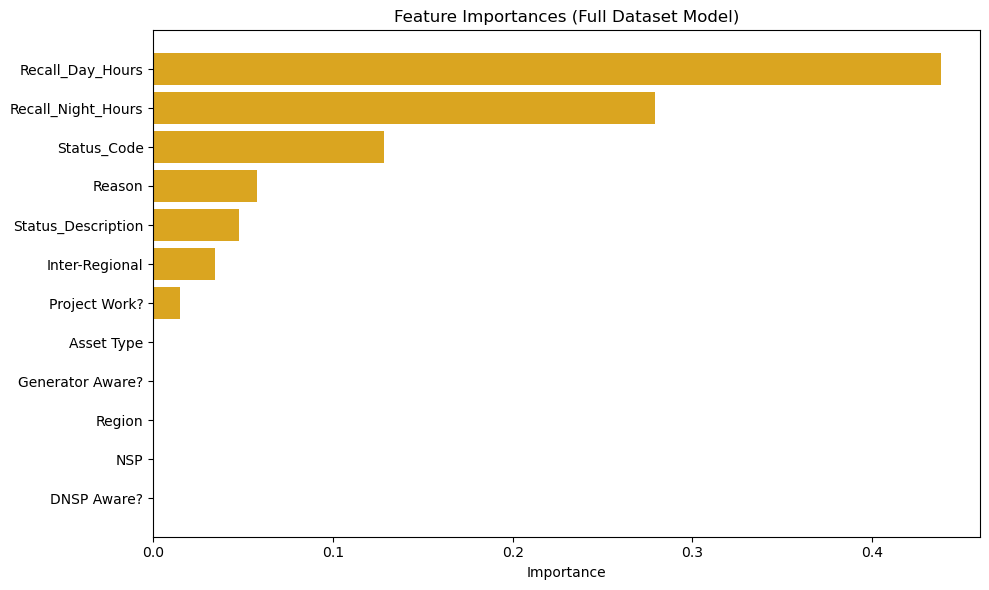

Training model for QLD...
Using provided parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/m

Cross-Validation Results (5-fold):
Test Accuracy: 0.8033 ± 0.0453
Test Precision: 0.7869 ± 0.0529
Test Recall: 0.8033 ± 0.0453
Test F1: 0.7720 ± 0.0574
Train Accuracy: 0.8324 ± 0.0114


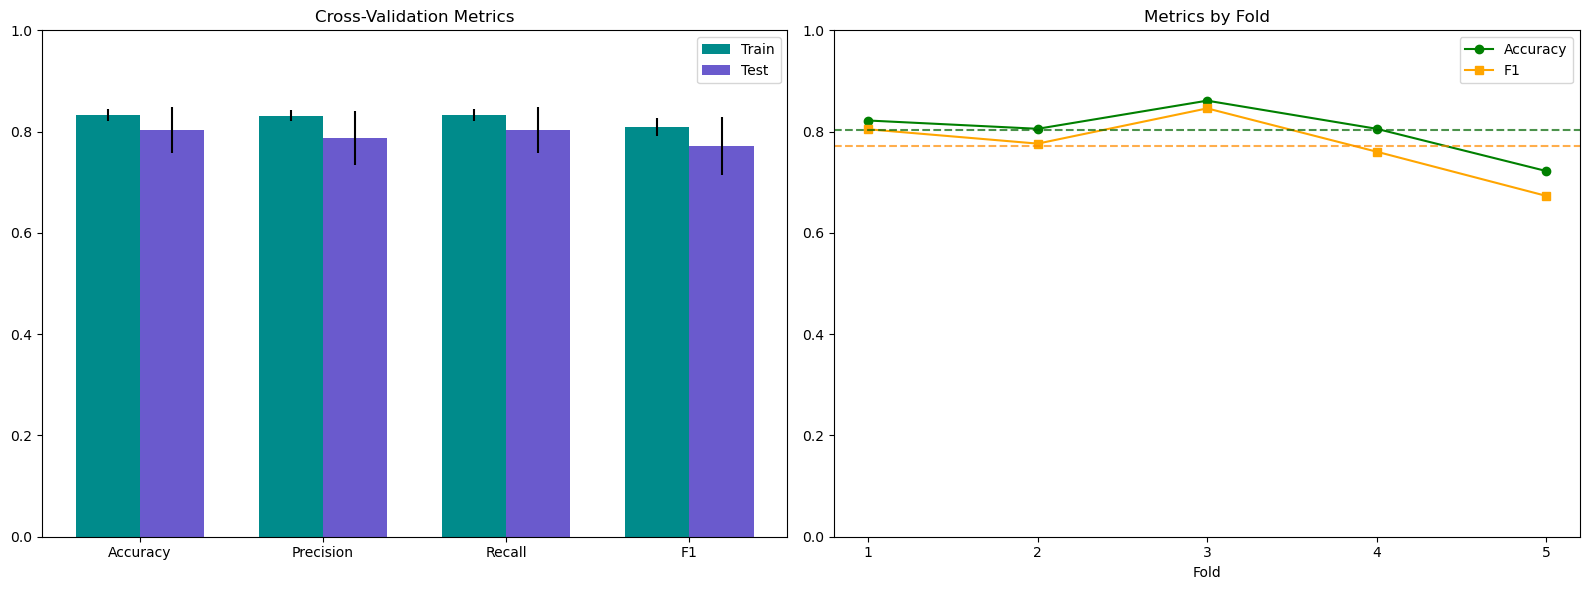

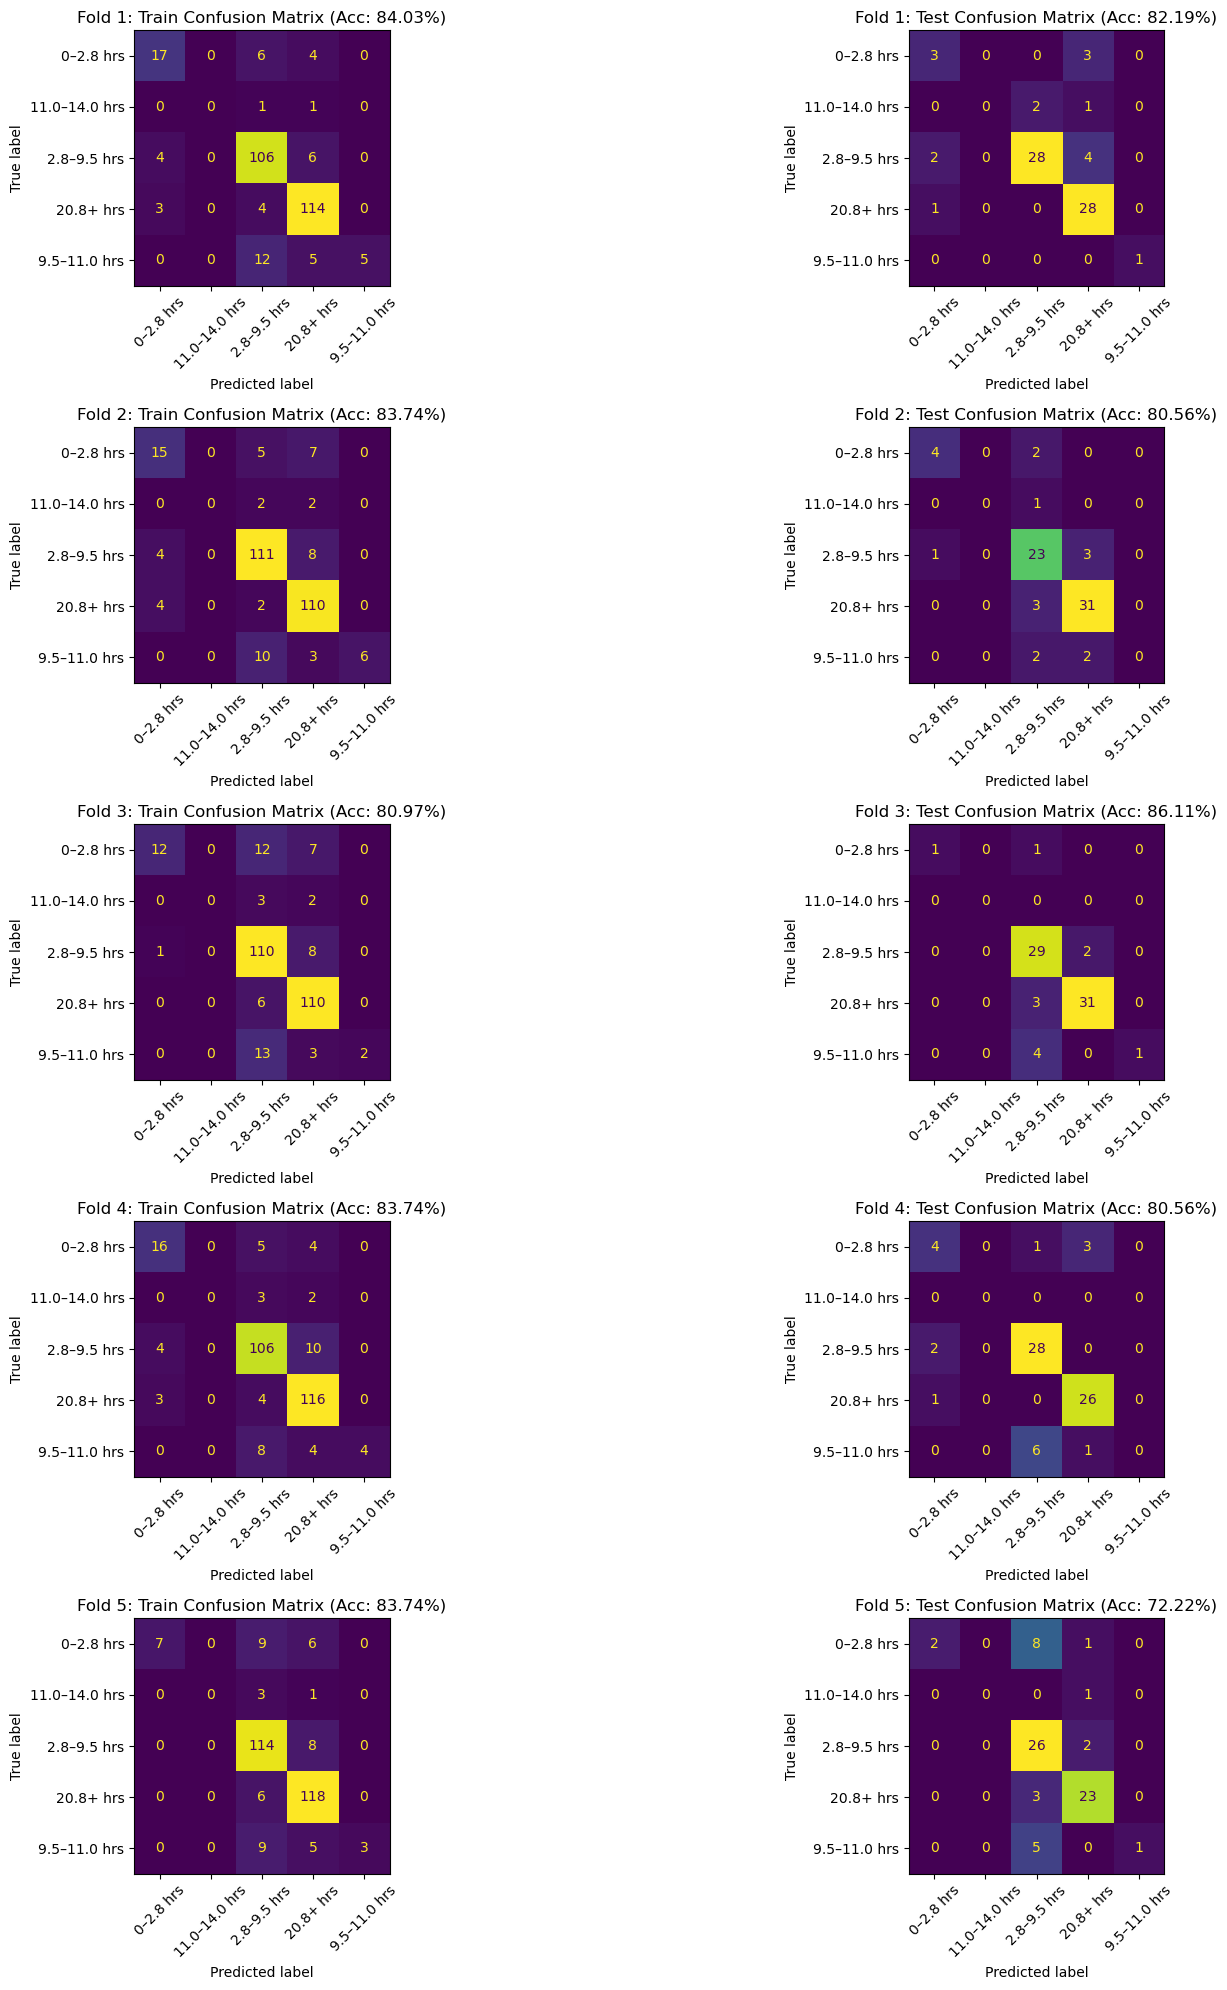

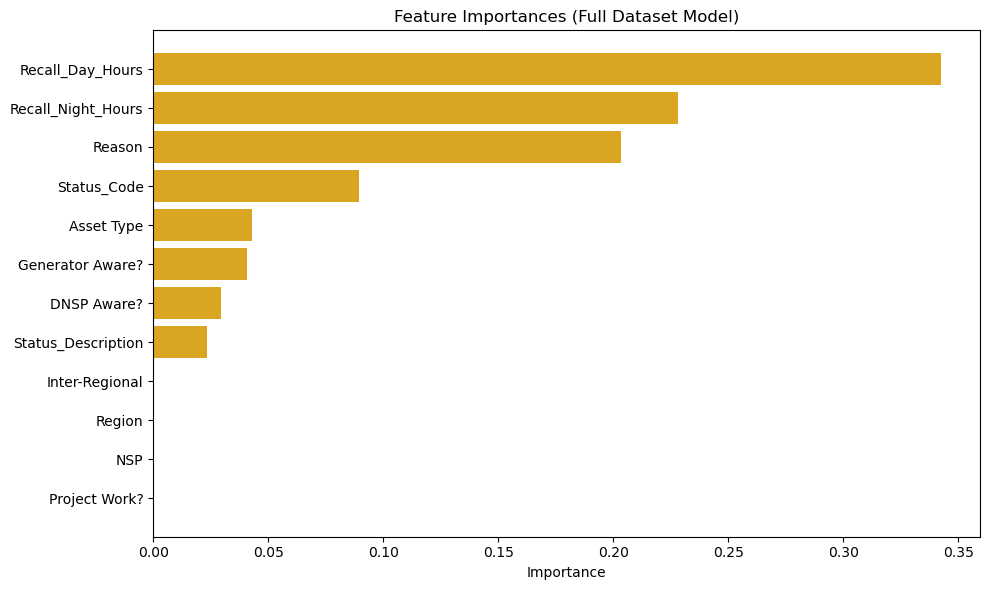

Training model for NSW...
Using provided parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/m

Cross-Validation Results (5-fold):
Test Accuracy: 0.7103 ± 0.0618
Test Precision: 0.6611 ± 0.0730
Test Recall: 0.7103 ± 0.0618
Test F1: 0.6760 ± 0.0713
Train Accuracy: 0.7890 ± 0.0110


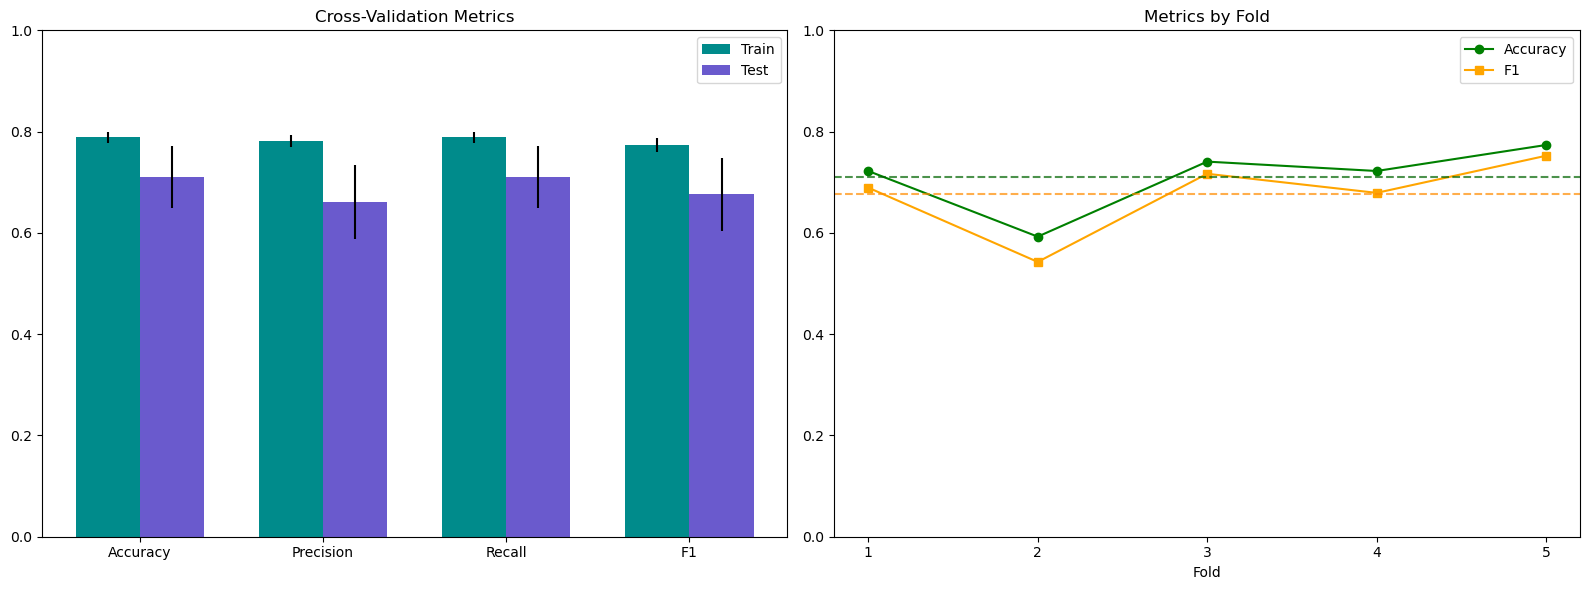

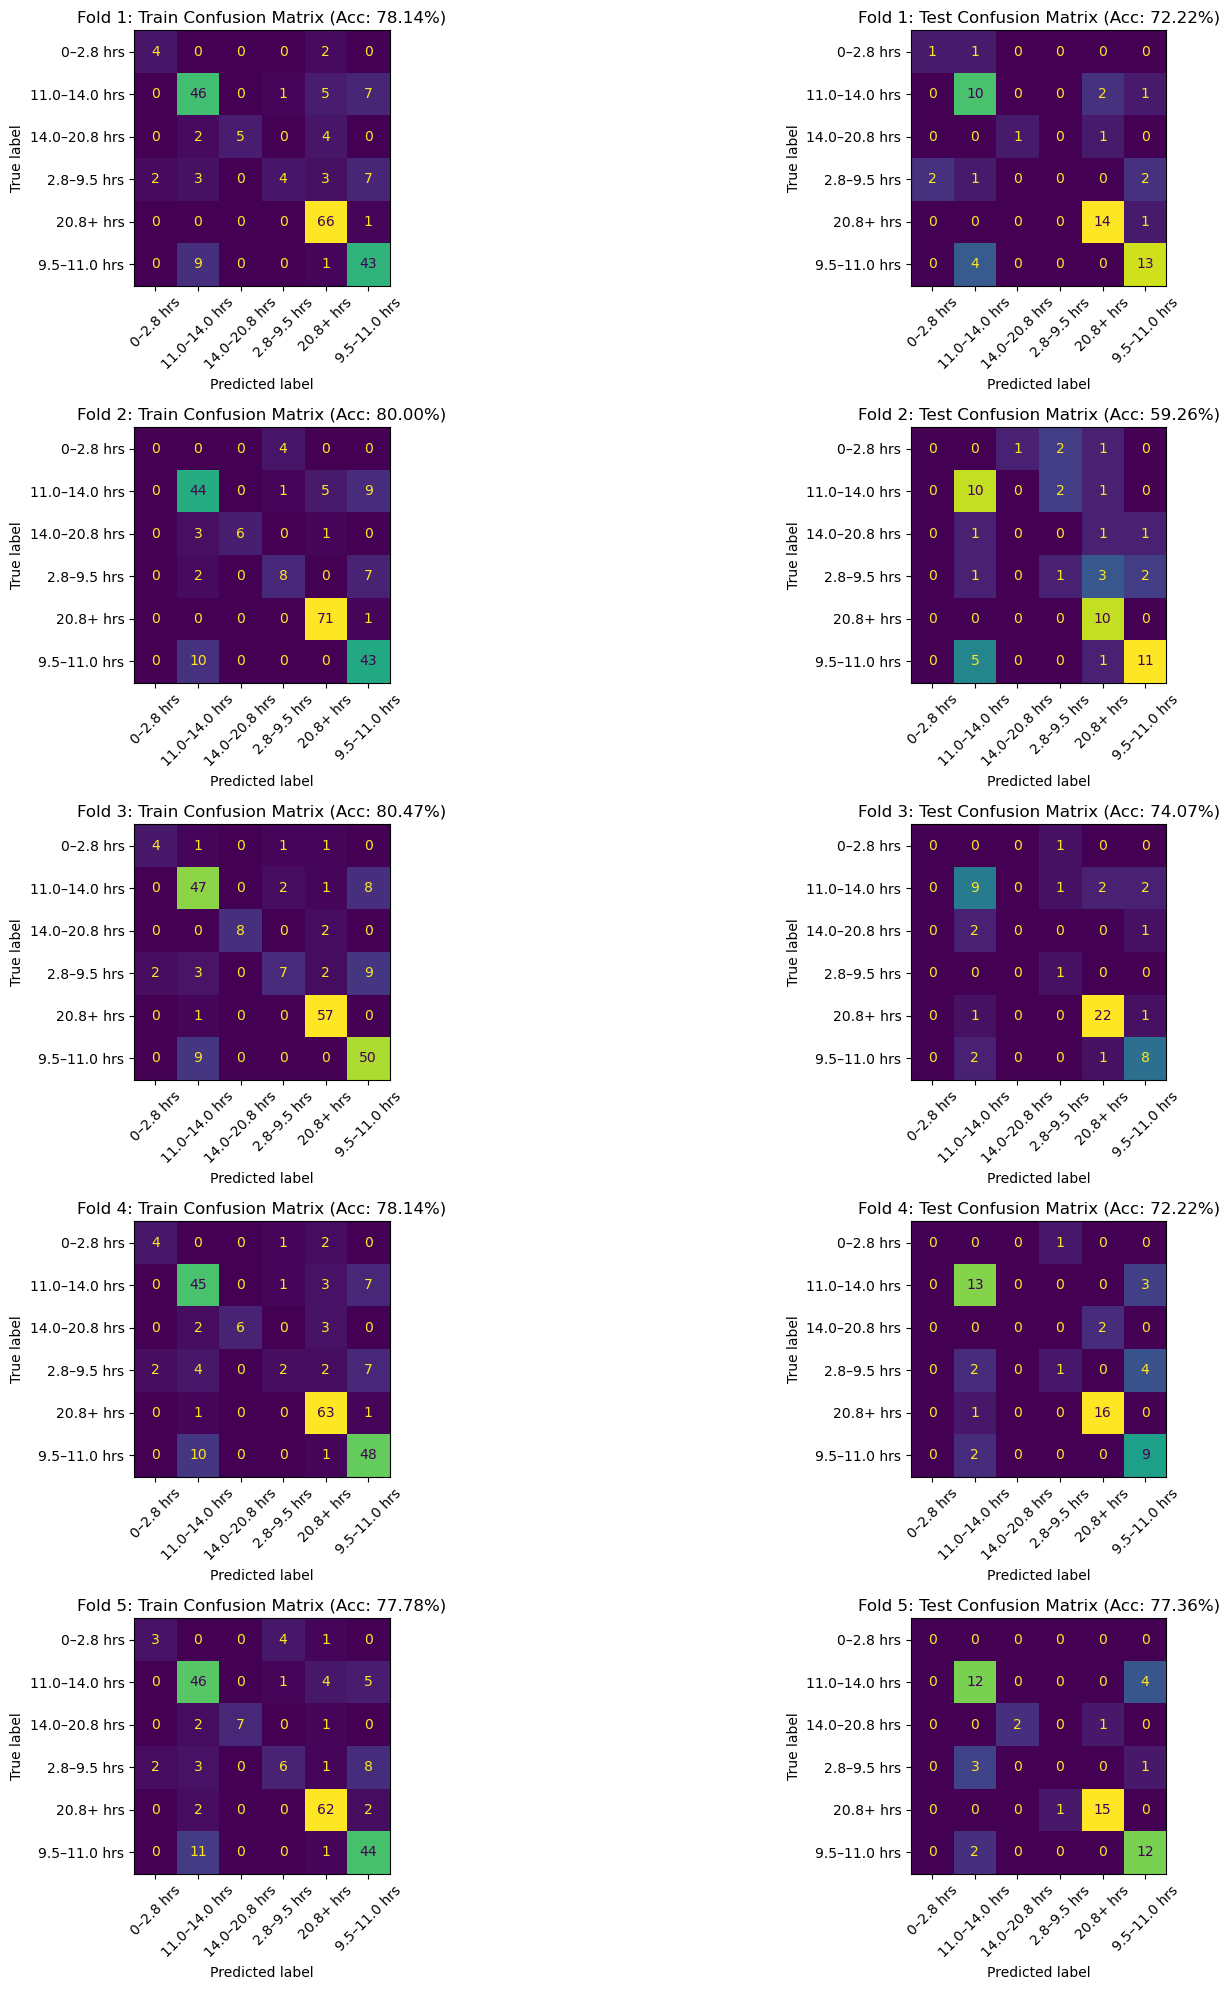

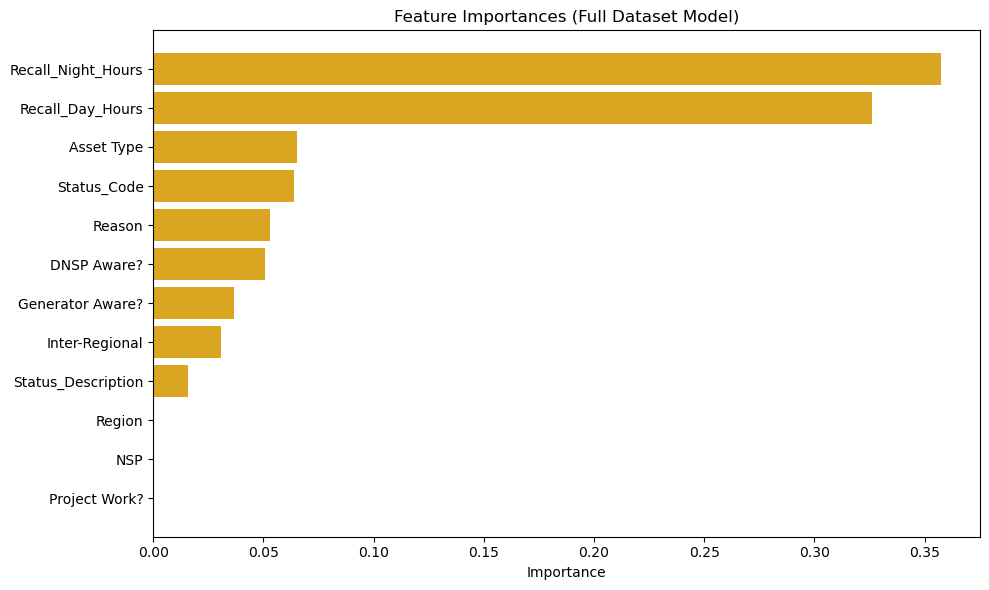

In [9]:
# Now, use the best hyperparameters to train models for each region
best_params = {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

# Define the function that runs cross-validation and fine-tuning for each state
def train_and_evaluate_for_each_state(df, column='Region', n_folds=5, fine_tune=False, params=None, random_state=42):
    # Dictionary to store models and results for each region/state
    region_models = {}
    region_cv_results = {}
    
    # Loop through each unique value in the 'Region' column (or any other column representing states)
    for region in df[column].unique():
        print(f"Training model for {region}...")
        
        # Filter the dataframe for the current region
        region_df = df[df[column] == region]
        
        # Train the model with cross-validation for the current region
        model, cv_results = train_with_cross_validation(region_df, n_folds=n_folds, fine_tune=False, params=best_params, random_state=random_state)
        
        # Store the trained model and results
        region_models[region] = model
        region_cv_results[region] = cv_results
    
    return region_models, region_cv_results

# Example usage:
# Assuming 'df' contains your dataset with a 'Region' column representing states
region_models, region_cv_results = train_and_evaluate_for_each_state(df, column='Region', n_folds=5)

